# 1) Carga de librerías

- Se importan las librerías pertinentes:

In [7]:
# GENERAL:
from src.constantes import *
from src.funciones import *
from src.clases import *

# ANALISIS EXPLORATORIO Y METRICAS
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 2) Carga de datos

- Carga del csv con los datos:

In [8]:
archivo_csv = '/ruta_de_datos/data.csv'  # Introducir ruta
# Crear una instancia de CSVReader
csv_reader = LectorCSV(archivo_csv)
df = csv_reader.crear_dataframe()
# Cambiao de los nombres de las columnas
df = df.rename(columns={"Unnamed: 0": "ID", "text": "TEXTO", "label": "CATEGORIA"})

# 3) Preprocesamiento de datos

- Se convierten las variables (columnas) a su tipo correspondiente.

In [9]:
# Convertimos las variables a su tipo correspondiente:
df['ID'] = df['ID'].astype(int)
df['TEXTO'] = df['TEXTO'].astype(str)
df['CATEGORIA'] = df['CATEGORIA'].astype(int)

In [10]:
# df = df.loc[0:250]

In [11]:
df.shape

(416809, 3)

- Se utiliza la clase "Preprocesado" y su función "limpieza" para limpiar y tokenizar los datos.

In [12]:
# Limpieza de la columna TEXTO
preprocesamiento = Preprocesado(df,'TEXTO')
df = preprocesamiento.limpieza()

/apps/works/citas_inss/pruebas_nico/proyecto/src_pruebas/clases.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Filtra las filas que contienen valores no nulos en ciertas columnas
/apps/works/citas_inss/pruebas_nico/proyecto/src_pruebas/clases.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def __init__(self, modelo_path, vectorizador_path, df=None, columna_texto=None):


In [13]:
df.shape

(416776, 5)

# 4) Clasificación y Predicción

- Modelo Regresión Logística

In [14]:
# Instanciar el clasificador con el DataFrame y la columna de texto
modelo_path_RL = "/ruta_del_modelo/modelo_TF_SDG_SW_L.pkl" # Introducir ruta
vectorizador_path_RL = "/ruta_del_vectorizador/vectorizador_TF_SDG_SW_L.pkl"  # Introducir ruta
df_1 = df
columna_texto_1 = 'TEXTO_STOPWORDS_LEMATIZACION'
# Suponiendo que tienes un DataFrame llamado df con una columna de texto llamada 'texto_columna'
clasificador_RL = CLasificadorTexto(modelo_path=modelo_path_RL, vectorizador_path=vectorizador_path_RL, df=df_1, columna_texto=columna_texto_1)
clasificaciones_RL = clasificador_RL.clasificar_columna_texto()
probabilidades_RL= clasificador_RL.predecir_probabilidades_columna_texto()

# 5) Métricas

- F-1 Score

In [15]:
etiquetas_reales = df['CATEGORIA']
etiquetas_predichas = clasificaciones_RL

# Convierte las probabilidades en las categorías correspondientes
etiquetas_probabilidades = probabilidades_RL.idxmax(axis=1)

# Calcula el F1-score
f1 = f1_score(etiquetas_reales, etiquetas_predichas, average='weighted')
print("F1-score:", f1)


F1-score: 0.9080718874712989


- Matriz de Confusión

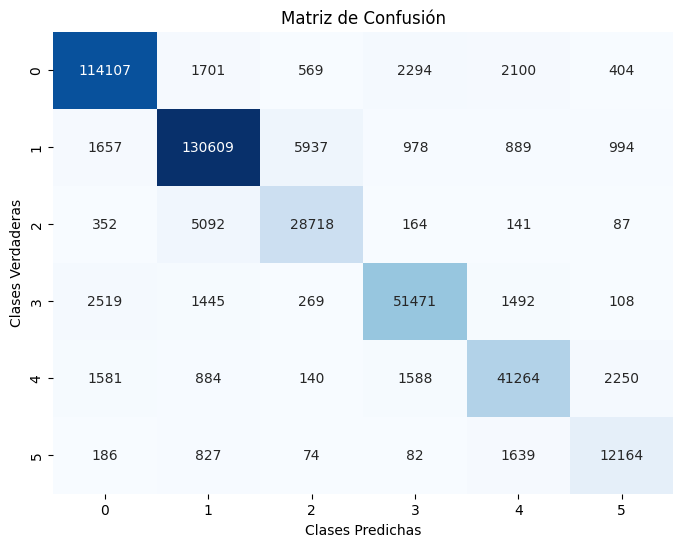

In [16]:
etiquetas_predichas = clasificaciones_RL
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(etiquetas_reales, etiquetas_predichas)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Clases Predichas")
plt.ylabel("Clases Verdaderas")
plt.title("Matriz de Confusión")
plt.show()

- Curva ROC "uno contra todos" (one-vs-all) 

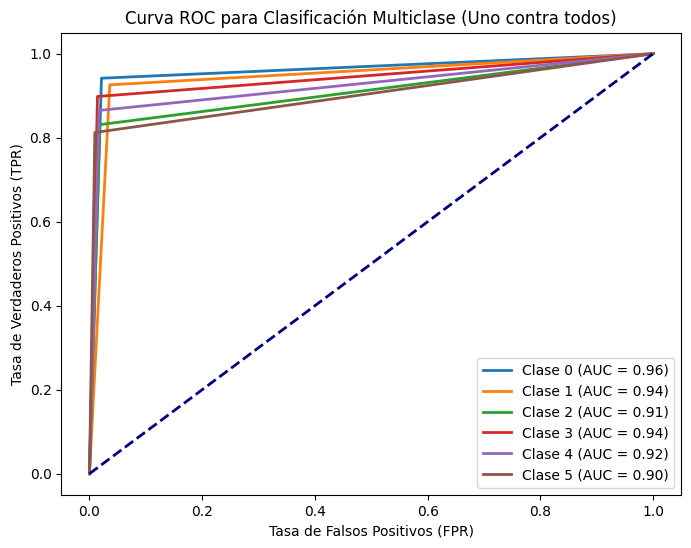

In [17]:
probabilidad_maxima = df['PROBABILIDAD_MAXIMA']

# Binarizar las etiquetas verdaderas y las predicciones
y_true_bin = label_binarize(etiquetas_reales, classes=[0, 1, 2, 3, 4, 5])
y_pred_bin = label_binarize(etiquetas_probabilidades, classes=[0, 1, 2, 3, 4, 5])

# Calcular la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):  # Se itera sobre cada clase
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Trazar la curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(6):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para Clasificación Multiclase (Uno contra todos)')
plt.legend(loc='lower right')
plt.show()

# 6) Análisis de resultados

- Se cambian los códigos de las clases por los nombres de las emociones antes de guardar el csv.

In [18]:
columnas_deseadas = ['ID', 'TEXTO', 'TEXTO_LIMPIO', 'CATEGORIA', 'CATEGORIA_MODELO', 'PROBABILIDADES_CATEGORIAS', 'PROBABILIDAD_MAXIMA']
df = df.loc[:, columnas_deseadas]

# Se define un diccionario de mapeo
mapeo_emociones = {
    0: 'Tristeza',
    1: 'Alegría',
    2: 'Amor',
    3: 'Ira',
    4: 'Miedo',
    5: 'Sorpresa'
}

# Se reemplazan los números por las emociones correspondientes
df['CATEGORIA_MODELO'] = df['CATEGORIA_MODELO'].replace(mapeo_emociones)
df['CATEGORIA'] = df['CATEGORIA'].replace(mapeo_emociones)

- Se realiza una agrupación de los resultados por categoría. Se muestran las clases reales (df['CATEGORIA']), y las clases predichas por el modelo (df['CATEGORIA_MODELO']).

In [19]:
# Calcular el porcentaje de conteo de emociones en las etiquetas reales
porcentaje_emociones_original = (df['CATEGORIA'].value_counts() / len(df['CATEGORIA'])) * 100
print("Porcentaje de conteo de emociones en las etiquetas reales:")
print(porcentaje_emociones_original)

# Calcular el porcentaje de conteo de emociones en las predicciones del modelo
porcentaje_emociones = (df['CATEGORIA_MODELO'].value_counts() / len(df['CATEGORIA_MODELO'])) * 100
print("\nPorcentaje de conteo de emociones en las predicciones del modelo:")
print(porcentaje_emociones)

Porcentaje de conteo de emociones en las etiquetas reales:
Alegría     33.846479
Tristeza    29.074371
Ira         13.749352
Miedo       11.446676
Amor         8.290784
Sorpresa     3.592337
Name: CATEGORIA, dtype: float64

Porcentaje de conteo de emociones en las predicciones del modelo:
Alegría     33.725071
Tristeza    28.888900
Ira         13.574918
Miedo       11.403008
Amor         8.567432
Sorpresa     3.840672
Name: CATEGORIA_MODELO, dtype: float64


- Cálculo de estadísticas descriptivas.

In [20]:
media = df['PROBABILIDAD_MAXIMA'].mean()
mediana = df['PROBABILIDAD_MAXIMA'].median()
desviacion_estandar = df['PROBABILIDAD_MAXIMA'].std()
minimo = df['PROBABILIDAD_MAXIMA'].min()
maximo = df['PROBABILIDAD_MAXIMA'].max()
# Imprimimos los resultados
print("Media:", media)
print("Mediana:", mediana)
print("Desviación estándar:", desviacion_estandar)
print("Valor mínimo:", minimo)
print("Valor máximo:", maximo)

Media: 0.9139397149878901
Mediana: 0.9924191375630993
Desviación estándar: 0.16250118480282957
Valor mínimo: 0.2539593714905058
Valor máximo: 0.9999999999799946


In [21]:
# Contar la cantidad de probabilidades menores que 0.50
cantidad_menores_a_0_50 = df[df['PROBABILIDAD_MAXIMA'] < 0.50].shape[0]
# Imprimir el resultado
print("Cantidad de probabilidades menores que 0.50:", cantidad_menores_a_0_50)

Cantidad de probabilidades menores que 0.50: 7778


# 7) Guardado de datos

In [22]:
clasificacion_csv = '/ruta_de_destino/clasificacion_visual.csv' # Introducir ruta

if df is not None:
    guardar = GuardarCSV(df)
    guardar.guardar_dataframe(clasificacion_csv, columnas=columnas_deseadas) # Opcional: especifica las columnas a guardar

El DataFrame fue guardado correctamente en /apps/works/citas_inss/pruebas_nico/proyecto/datos/clasificacion_visual.csv


___________________________________________________________________________________________________________________________________________________________________________________

In [5]:
clasificacion_csv = '/ruta_clasificacion/clasificacion_visual.csv' # Introducir ruta
# Crear una instancia de CSVReader
csv_reader = LectorCSV(clasificacion_csv)
df_clasificado = csv_reader.crear_dataframe()

In [6]:
df_clasificado

,ID,TEXTO,TEXTO_LIMPIO,CATEGORIA,CATEGORIA_MODELO,PROBABILIDADES_CATEGORIAS,PROBABILIDAD_MAXIMA
0,0,i just feel really helpless and heavy hearted,just feel really helpless and heavy hearted,Miedo,Miedo,"[0.456974935767591, 1.161457601962075e-05, 0.0...",0.541159
1,1,ive enjoyed being able to slouch about relax a...,ive enjoyed being able to slouch about relax a...,Tristeza,Tristeza,"[0.9714115838022704, 0.027724774904544586, 1.2...",0.971412
2,2,i gave up my internship with the dmrg and am f...,gave up my internship with the dmrg and am fee...,Miedo,Miedo,"[8.645249027206968e-05, 0.010573842822176275, ...",0.985919
3,3,i dont know i feel so lost,dont know feel so lost,Tristeza,Tristeza,"[0.9389417977415544, 0.05159940785344678, 0.00...",0.938942
4,4,i am a kindergarten teacher and i am thoroughl...,am kindergarten teacher and am thoroughly wear...,Miedo,Alegría,"[0.18131757488134664, 0.48614674629451415, 0.0...",0.486147
...,...,...,...,...,...,...,...
416771,416804,i feel like telling these horny devils to find...,feel like telling these horny devils to find s...,Amor,Amor,"[0.00010588892987993045, 0.001009086713858359,...",0.993164
416772,416805,i began to realize that when i was feeling agi...,began to realize that when was feeling agitate...,Ira,Miedo,"[1.8102717515589728e-16, 5.013768445686416e-13...",0.814289
416773,416806,i feel very curious be why previous early dawn...,feel very curious be why previous early dawn i...,Sorpresa,Sorpresa,"[1.4220417567670309e-06, 4.806076076604596e-06...",0.993257
416774,416807,i feel that becuase of the tyranical nature of...,feel that becuase of the tyranical nature of t...,Ira,Ira,"[0.011694101192477237, 0.05705407992987094, 0....",0.929824
